![ieseg logo](./img/ieseg.png)

#### MBD 2020-2021
# Credit Scoring Individual Assignment

## Prineet Kaur Bhurji

PROJECT GOAL - As a Data Scientist hired for the given Bank, need to develop a Credit Scorecard from the partially anonymized dataset provided as sample of accepted applicants and a sample of rejected applicants. Aim is to develop the best possible scorecard by choosing the appropriate evaluation procedure. The data provided by the bank includes -
- The ACCEPTS file with 10000 entries and 19 columns
- The REJECTS file with 5000 entries and 19 columns. 

PROJECT OUTCOME - A best possible Credit Scorecard, presented and discussed clearly backedup by a thorough evaluation of the performance of the model along with a Survival Analysis Model

In [1]:
#pip install category-encoders

In [2]:
# Loading the required libraries
import pandas as pd
import numpy as np
from numpy import where
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from category_encoders import *
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report,confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, log_loss, accuracy_score
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Reading the Data Files

In [3]:
ACCEPTS = pd.read_excel('ACCEPTS.xlsx', index_col=0)
REJECTS = pd.read_excel('REJECTS.xlsx', index_col=0)

In [4]:
ACCEPTS.head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,Days_late,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio,Default_45
ID,,,,,,,,,,,,,,,,,,
250263,1,1,11,5,6,7,1,2,0,1,0,NaN,1.438518,-0.259085,1.781040,0.860269,0.513980,0
250290,1,2,6,4,5,1,1,2,1,1,0,1.498183,0.204811,0.383312,1.107163,-0.718249,1.796590,0
250249,2,3,11,5,7,7,1,2,1,1,0,-0.241731,-0.852651,-0.732430,1.406664,1.122930,-0.768631,0
249516,3,3,10,4,2,4,1,2,0,1,168,NaN,-0.676407,-0.057350,0.957412,-1.702482,0.513980,1
249827,1,3,5,2,4,4,1,3,0,1,0,NaN,-0.412042,-0.574648,-0.390342,0.910077,-0.768631,0


In [5]:
REJECTS.head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio
ID,,,,,,,,,,,,,,,,
305932,3,3,14,2,1,5,1,1,1,1,-0.030455,-0.323920,-0.605449,-1.064220,1.028210,-0.768631
305764,1,4,7,1,6,4,1,2,1,1,0.715222,5.668368,1.299572,0.807662,1.081778,1.796590
305971,1,4,10,4,5,4,1,4,1,3,0.764933,-0.750782,0.434027,-0.390342,-0.969416,1.796590
305664,1,5,14,2,2,5,3,3,1,1,-1.347818,-0.852651,-0.490122,-0.989344,1.046303,-0.768631
305639,1,4,15,1,5,4,1,3,1,2,1.634890,3.200955,0.561380,0.583036,0.088464,1.796590


## Cleaning the Datasets

In [6]:
# Understanding the datatypes and number of values in each column of the datasets
ACCEPTS.info()
REJECTS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 250263 to 305891
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   V1                   10000 non-null  int64  
 1   V2                   10000 non-null  int64  
 2   V3                   10000 non-null  int64  
 3   V4                   10000 non-null  int64  
 4   V5                   10000 non-null  int64  
 5   V6                   10000 non-null  int64  
 6   V7                   10000 non-null  int64  
 7   V8                   10000 non-null  object 
 8   Has_FICO             10000 non-null  int64  
 9   Business_channel     10000 non-null  int64  
 10  Days_late            10000 non-null  int64  
 11  FICO_Score           5528 non-null   float64
 12  Loan_amount          10000 non-null  float64
 13  Monthly_income       10000 non-null  float64
 14  Age                  10000 non-null  float64
 15  Gearing_coefficient  10000 non

As we see above, ACCEPTS dataset has an extra column as compared to REJECTS. We can go ahead and Drop it!

In [7]:
# Droping the Days_late column in ACCEPTS
ACCEPTS = ACCEPTS.drop(columns = ["Days_late"], axis=1)

In [8]:
ACCEPTS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 250263 to 305891
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   V1                   10000 non-null  int64  
 1   V2                   10000 non-null  int64  
 2   V3                   10000 non-null  int64  
 3   V4                   10000 non-null  int64  
 4   V5                   10000 non-null  int64  
 5   V6                   10000 non-null  int64  
 6   V7                   10000 non-null  int64  
 7   V8                   10000 non-null  object 
 8   Has_FICO             10000 non-null  int64  
 9   Business_channel     10000 non-null  int64  
 10  FICO_Score           5528 non-null   float64
 11  Loan_amount          10000 non-null  float64
 12  Monthly_income       10000 non-null  float64
 13  Age                  10000 non-null  float64
 14  Gearing_coefficient  10000 non-null  float64
 15  Max_gearing_ratio    10000 non

### Dealing with Missing Values

In [9]:
# Checking for the Missing Values 
print("Missing Fico Scores")
print("In ACCEPTS Dataset =",ACCEPTS['FICO_Score'].isna().sum())
print("In REJECTS Dataset =",REJECTS['FICO_Score'].isna().sum())

Missing Fico Scores
In ACCEPTS Dataset = 4472
In REJECTS Dataset = 2086


In [10]:
# Filling the Missing Values with Median
ACCEPTS['FICO_Score'] = ACCEPTS['FICO_Score'].fillna(ACCEPTS['FICO_Score'].median())
REJECTS['FICO_Score'] = REJECTS['FICO_Score'].fillna(REJECTS['FICO_Score'].median())

### Checking for the Unique Values

In [11]:
# Accepts Dataset
for i in ACCEPTS.loc[:, ACCEPTS.columns.str.startswith('V')]:
    print(i,ACCEPTS[i].unique())

V1 [1 2 3 4 5]
V2 [1 2 3 4 5 6]
V3 [11  6 10  5 12 14 15  3  2 13  1  7  4  8  9 16]
V4 [5 4 2 3 1 6]
V5 [6 5 7 2 4 3 1]
V6 [7 1 4 5 6 2 3]
V7 [1 3 2]
V8 ['2' '3' '4' '1' '>4']


In [12]:
# Rejects Dataset
for i in REJECTS.loc[:, REJECTS.columns.str.startswith('V')]:
    print(i,REJECTS[i].unique())

V1 [3 1 4 2 5]
V2 [3 4 5 1 2]
V3 [14  7 10 15  2  5 11  3  8  1 12  6 13  4  9]
V4 [2 1 4 5 3]
V5 [1 6 5 2 4 3 7]
V6 [5 4 7 3 1 6 2]
V7 [1 3 2]
V8 ['1' '2' '4' '3' '>4']


After observing the Unique values we can see that the V8 column has an abnormal value '>4'. To fit with the sequence we can change it to 5

In [13]:
ACCEPTS['V8'] = where(ACCEPTS['V8'] == '>4',5,ACCEPTS['V8']).astype(int)
REJECTS['V8'] = where(REJECTS['V8'] == '>4',5,REJECTS['V8']).astype(int)

## Exploratory Data Analysis (EDA)

In [14]:
# Creating a function for Plotting Graphs
def data_plot(data,col):
    countplt=sns.countplot(x=col, data=data, palette ='mako')
    plt.show()

### Understanding the Count of Defaulters

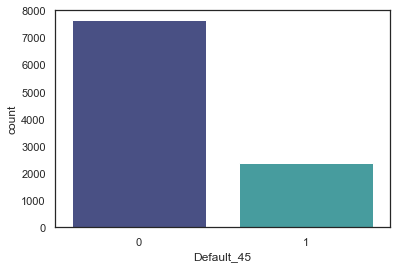

0    7636
1    2364
Name: Default_45, dtype: int64

In [15]:
data_plot(ACCEPTS,"Default_45")
ACCEPTS["Default_45"].value_counts()

###  Understanding the Distribution of Defaulters across Business Channels

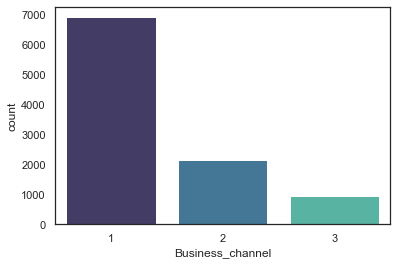

1    6912
2    2144
3     944
Name: Business_channel, dtype: int64

In [16]:
data_plot(ACCEPTS,"Business_channel")
ACCEPTS["Business_channel"].value_counts()

As seen above, maximum Defaulters are coming from Business Channel 1 followed by Channel 2 and Channel 3

###  Understanding the Distribution of Age and Defaulters across Business Channels

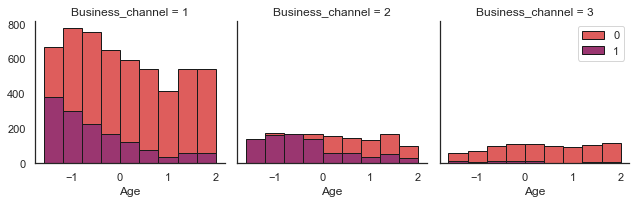

In [17]:
temp = np.linspace(ACCEPTS.Age.min(), ACCEPTS.Age.max(), 10)
a = sns.FacetGrid(ACCEPTS, col="Business_channel", hue="Default_45", palette="flare", col_wrap=3)
a.map(plt.hist, 'Age', bins=temp, ec="k")

a.axes[-1].legend()
plt.show()

### Understanding the Distribution of Loan Amounts

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Loan_amount', ylabel='Density'>

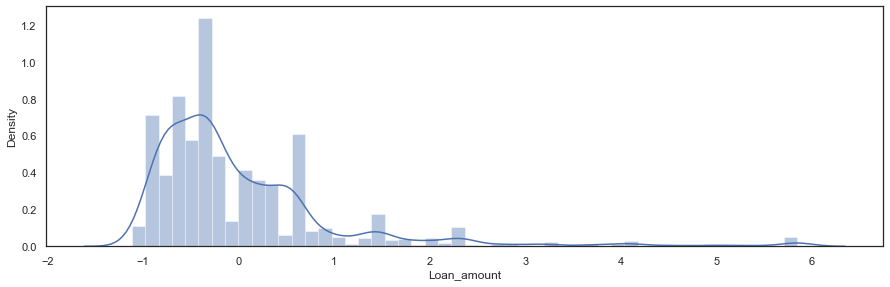

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(3, 1, 1); sns.distplot(ACCEPTS['Loan_amount'])

### Understanding the Distribution of Monthly Income

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monthly_income', ylabel='Density'>

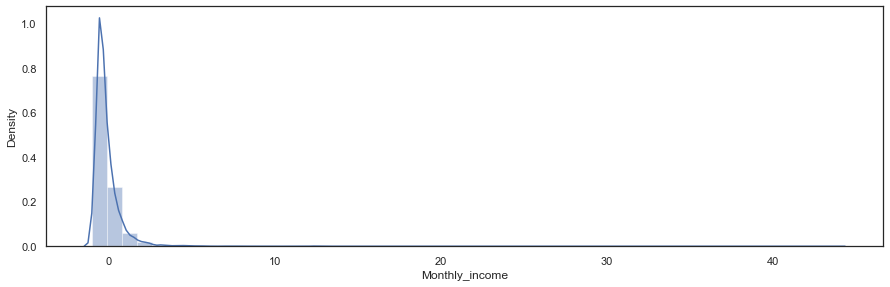

In [19]:
plt.figure(figsize=(15,15))
plt.subplot(3, 1, 1); sns.distplot(ACCEPTS['Monthly_income'])

### Understanding the Trend between Loan Amount and Monthly Income

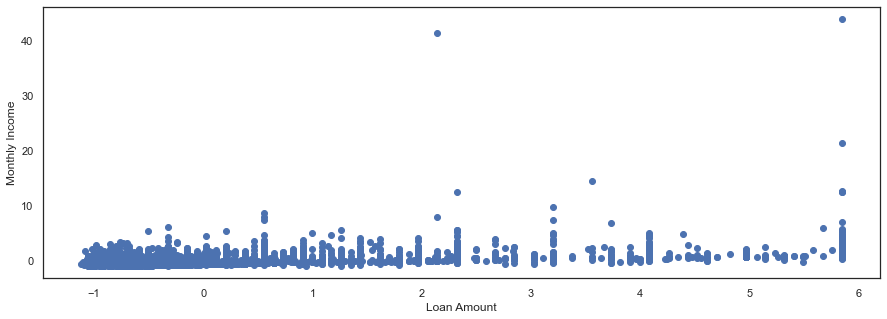

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(ACCEPTS['Loan_amount'],ACCEPTS['Monthly_income'])
ax.set_xlabel('Loan Amount')
ax.set_ylabel('Monthly Income')
plt.show()

The above Scatter plot tells that more Customers having Loan have less Monthly Income

## Weight of Evidence (WOE)

The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan and "Good Customers" refers to the customers who paid back loan.
(Reference - https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)

WOE Calculation - 

![WOE](./img/woe.png)

where,
- Distribution of Goods = % of Good Customers in a particular group
- Distribution of Bads = % of Bad Customers in a particular group
- ln = Natural Log

Positive WOE means Distribution of Goods > Distribution of Bads and Negative WOE means Distribution of Goods < Distribution of Bads

Usage of WOE - 
Weight of Evidence helps to transform a continuous independent variable into a set of groups or bins based on similarity of dependent variable distribution i.e. number of events and non-events.

### We will try to get the "Weight of Evidence" for each Variable w.r.t Target Variable on the ACCEPTS data set.

In [21]:
# Creating Train & Validation sets 
train, validation = train_test_split(ACCEPTS, test_size=0.30, random_state = 1)

#### Getting the WOE for Trainset

In [22]:
features = list(train.columns)
features.remove('Default_45')
woe_map = WOEEncoder(cols=features).fit(train, train['Default_45'])
train_set = woe_map.transform(train)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [23]:
train_set[features].head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio
ID,,,,,,,,,,,,,,,,
267817,0.088720,0.284703,0.338596,0.277962,-0.298049,0.417935,0.347647,-0.305746,-0.104843,-1.113025,1.645908,0.000000,0.172602,0.277962,1.153431,0.123293
289379,0.551488,0.106659,0.527725,0.135091,0.096400,0.417935,0.347647,-0.305746,-0.104843,-0.175561,-0.520545,0.211388,0.237140,0.035401,-0.792479,-0.037791
265845,0.088720,0.284703,-0.355874,-0.785580,-0.782223,-0.835913,-0.276549,0.339190,0.121052,-0.175561,0.120375,0.155660,0.460284,-0.870951,0.306133,-0.037791
265600,0.551488,0.106659,0.109423,0.277962,0.096400,0.417935,-0.276549,0.339190,-0.104843,-0.175561,0.000000,0.491056,1.558896,0.712459,0.000000,-0.032814
289457,-0.335254,0.106659,-0.355874,-0.160451,0.096400,0.417935,-0.276549,-0.305746,0.121052,-0.175561,0.120375,-0.285507,-0.099332,0.395145,0.460284,-0.037791


#### Getting the WOE for Validationset

In [24]:
features = list(validation.columns)
features.remove('Default_45')
woe_map = WOEEncoder(cols=features).fit(validation, validation['Default_45'])
val_set = woe_map.transform(validation)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [25]:
val_set[features].head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio
ID,,,,,,,,,,,,,,,,
305474,-0.307406,0.099838,0.402878,-0.025034,0.620744,-0.094525,0.373503,-0.279254,-0.079666,-0.180440,0.926126,-0.317668,0.000000,-0.395630,1.906955,-0.034069
278297,0.594249,0.350479,0.341192,0.266824,-0.810574,0.469236,0.373503,0.351584,0.096013,-0.180440,0.095074,0.012163,0.115196,0.159647,0.000000,0.122978
284024,0.594249,0.099838,0.115196,0.266824,-0.342986,-0.237025,0.373503,0.351584,-0.079666,0.752043,1.619273,0.115196,0.000000,0.460036,0.000000,-0.043148
278610,-0.307406,-0.320765,-0.333398,-0.837463,-0.869303,-0.876444,-0.275786,-0.279254,0.096013,-0.180440,0.095074,0.134998,0.520661,-0.556898,0.000000,-0.034069
287120,0.594249,0.099838,0.074922,0.266824,0.270924,-0.094525,0.373503,0.351584,0.096013,-0.180440,0.095074,-0.080919,1.213808,0.352326,0.000000,-0.034069


## Feature Importance

### Analyzing the Correlation between various Variables

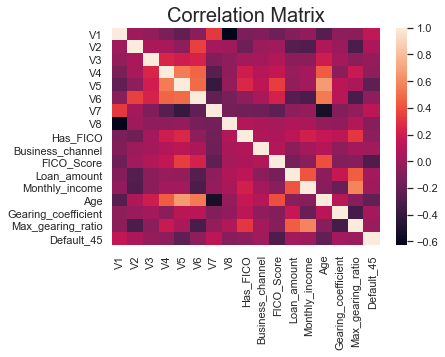

In [26]:
num_corr = ACCEPTS.corr()
sns.heatmap(num_corr, cbar=True, cmap="rocket")
plt.title("Correlation Matrix", fontsize=20,)
plt.show()

As seen above, few variables have a significant correlation with each other, especially the anonymized variables.

In [27]:
np.random.seed(123)

In [28]:
len(features)

16

In [29]:
# Initializing an Empty Array to hold Feature Importances
feature_importances = np.zeros(16)

# Creating the Model with several Hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [30]:
# Fittng the Model twice to avoid Overfitting
for i in range(2):
    # Train using Early Stopping
    model.fit(train_set[features], train_set["Default_45"], early_stopping_rounds=500, eval_set = [(val_set[features], val_set["Default_45"])], 
              eval_metric = 'auc', verbose = 200)
    
    # Recording the Feature Importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.906041	valid_0's binary_logloss: 0.423265
[400]	valid_0's auc: 0.900748	valid_0's binary_logloss: 0.429979
Early stopping, best iteration is:
[55]	valid_0's auc: 0.91879	valid_0's binary_logloss: 0.44724
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.906041	valid_0's binary_logloss: 0.423265
[400]	valid_0's auc: 0.900748	valid_0's binary_logloss: 0.429979
Early stopping, best iteration is:
[55]	valid_0's auc: 0.91879	valid_0's binary_logloss: 0.44724


In [31]:
# Averaging the Feature Importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importances}).sort_values('importance', ascending = False)

In [32]:
feature_importances

,feature,importance
12,Monthly_income,274.0
14,Gearing_coefficient,266.0
10,FICO_Score,194.0
11,Loan_amount,171.0
13,Age,169.0
2,V3,93.0
4,V5,73.0
9,Business_channel,71.0
1,V2,60.0
3,V4,59.0


As all Features have some Importance, will go ahead with retaining All of them!

## Modeling

In this section, we run the train and test set on different models and decide on the best one on basis of AUC and Accuracy

In [33]:
# Assign the Target Column
target = "Default_45"

In [34]:
Tree               = DecisionTreeClassifier()
Logistic           = LogisticRegression(solver = "lbfgs", max_iter=1000)  
RandomForest       = RandomForestClassifier()                             
BoostedTree        = GradientBoostingClassifier()                         
SVM                = SVC(gamma = "scale", probability = True)             
ADAboost           = AdaBoostClassifier()                                 
Catboost           = CatBoostClassifier(task_type = 'CPU',verbose=False)  
LinearDiscriminant = LinearDiscriminantAnalysis()
NeuralNet          = MLPClassifier()
Neighbors          = KNeighborsClassifier()
Xboost             = XGBClassifier()

In [35]:
# Defining the Models as dictionary to run them All together
models = {"Tree"               :Tree,
          "Logistic"           :Logistic,
          "RandomForest"       :RandomForest,
          "BoostedTree"        :BoostedTree,
          "SVM"                :SVM,
          "ADAboost"           :ADAboost,
          "Catboost"           :Catboost,
          "LinearDiscriminant" :LinearDiscriminant,
          "NeuralNet"          :NeuralNet,
          "Neighbors"          :Neighbors,
          "Xboost"             :Xboost
         }

In [36]:
# Fitting the Models
for model in models:
    models[model].fit(train_set[features],train_set[target])
    print(f"{model} has been trained successfully")

Tree has been trained successfully
Logistic has been trained successfully
RandomForest has been trained successfully
BoostedTree has been trained successfully
SVM has been trained successfully
ADAboost has been trained successfully
Catboost has been trained successfully
LinearDiscriminant has been trained successfully


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


NeuralNet has been trained successfully
Neighbors has been trained successfully
[14:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xboost has been trained successfully


In [37]:
# Checking the Performances of various Models on Training Set

performances_train = {}

for model in models:
    predictions   = models[model].predict(train_set[features])
    probabilities = pd.DataFrame(models[model].predict_proba(train_set[features]))[1]
    accuracy      = accuracy_score(train_set[target],predictions)
    auc           = roc_auc_score(np.array(train_set[target]),np.array(probabilities))
    
    performances_train[model] = {"Accuracy":accuracy,"AUC":auc}

In [38]:
pd.DataFrame(performances_train)

,Tree,Logistic,RandomForest,BoostedTree,SVM,ADAboost,Catboost,LinearDiscriminant,NeuralNet,Neighbors,Xboost
Accuracy,1.0,0.856286,0.999857,0.875429,0.871714,0.858000,0.928857,0.854857,0.884571,0.881857,0.969429
AUC,1.0,0.897969,1.000000,0.930787,0.902059,0.913979,0.972494,0.896113,0.931595,0.936369,0.995260


In [39]:
# Checking the Performances of various Models on Validation Set

performances_validate = {}

for model in models:
    predictions   = models[model].predict(val_set[features])
    probabilities = pd.DataFrame(models[model].predict_proba(val_set[features]))[1]
    accuracy      = accuracy_score(val_set[target],predictions)
    auc           = roc_auc_score(np.array(val_set[target]),np.array(probabilities))
    
    performances_validate[model] = {"Accuracy":accuracy,"AUC":auc}

In [40]:
pd.DataFrame(performances_validate)

,Tree,Logistic,RandomForest,BoostedTree,SVM,ADAboost,Catboost,LinearDiscriminant,NeuralNet,Neighbors,Xboost
Accuracy,0.771333,0.854333,0.859000,0.854667,0.860000,0.841667,0.861000,0.852333,0.851667,0.827667,0.841000
AUC,0.738446,0.901372,0.905759,0.916637,0.875638,0.903010,0.920316,0.895999,0.892658,0.827497,0.898168


From the above we see that CatBoost is the Best Performing Model

## Hyperparameter Tuning

Let's tune the model by find the best hyper parameters of the model. We will do a randomized grid search.

In [41]:
CB_grid = CatBoostClassifier(eval_metric = 'AUC',loss_function='Logloss',task_type = 'CPU',verbose = False)
grid = {'learning_rate': [0.03,0.1,0.2,0.05], 
        'depth': [5,6,7,8,9,10,11,12], 
        'iterations' : range(100,1000,100), 
        'l2_leaf_reg': [4,5,6,7,8,9]}

randomized_search_result = CB_grid.randomized_search(grid, X=train_set[features], y=train_set[target], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.911767921
bestIteration = 251

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9117679	best: 0.9117679 (0)	total: 4.54s	remaining: 40.8s

bestTest = 0.9122612291
bestIteration = 110

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9122612	best: 0.9122612 (1)	total: 6.25s	remaining: 25s

bestTest = 0.9127545372
bestIteration = 128

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9127545	best: 0.9127545 (2)	total: 9.42s	remaining: 22s

bestTest = 0.914245673
bestIteration = 48

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.9142457	best: 0.9142457 (3)	total: 10.6s	remaining: 16s

bestTest = 0

In [42]:
randomized_search_result['params']
{'depth': 8, 'l2_leaf_reg': 7, 'iterations': 200, 'learning_rate': 0.2}

{'depth': 8, 'l2_leaf_reg': 7, 'iterations': 200, 'learning_rate': 0.2}

Let's apply the Best Parameters and run the model.

In [43]:
# Applying the Best Parameters to run the Model.

cb = CatBoostClassifier(custom_metric=['TotalF1'], l2_leaf_reg = 7,early_stopping_rounds=48,depth = 8, iterations = 200, learning_rate = 0.2, eval_metric='AUC',verbose=False)

cb.fit(train_set[features], train_set[target],
          eval_set=(val_set[features], val_set[target]), plot=True, verbose=False, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

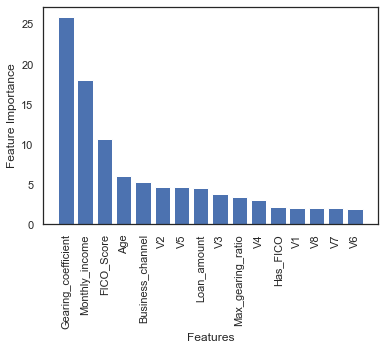

In [44]:
# Plotting the Features
feat_imp=cb.get_feature_importance(prettified=True)
plt.bar(feat_imp['Feature Id'], feat_imp['Importances'])
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.xticks(rotation=90)

As we can see from above plot - Gearing coefficient, Monthly Income, Fico Score are the features with the Highest Importance.

## Plotting ROC, Precision and Recall

In [45]:
# Creating a function for Plotting ROC Curve

def performancepara1(model, X_test, y_test):

    print(model)
    
    # Make predictions on test set
    y_pred=model.predict(X_test)
    y_pred=np.round(y_pred)

    # Confusion matrix
    print(confusion_matrix(y_test, y_pred))
    
    # AUC score
    y_pred_prob = model.predict_proba(X_test)
    print("AUC score: ", roc_auc_score(y_test, y_pred_prob[:,1]))

    # Logloss
    print("Logloss : ", log_loss(y_test, y_pred_prob))
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
    plt.plot([0, 1], [0, 1],'k--')
    plt.plot(fpr, tpr, label='CatBoost')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

[[2132  182]
 [ 252  434]]
AUC score:  0.9179150361218695
Logloss :  0.30709917598280007


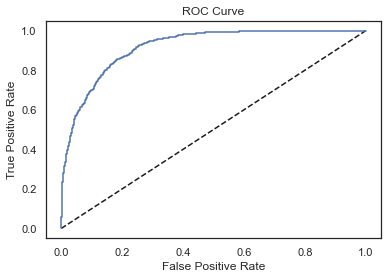

In [46]:
performancepara1(cb, val_set[features], val_set["Default_45"])

In [47]:
# Creating a function for Plotting Precision vs Recall

def performancepara2(model, X_test, y_test):

    print(model)
    
    # Make predictions on test set
    y_pred=model.predict(X_test)
    y_pred=np.round(y_pred)

    # Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=18)
    plt.ylabel("Precision", fontsize=18)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.show()

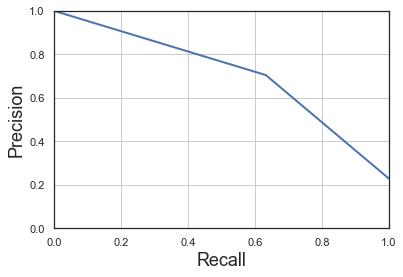

In [48]:
performancepara2(cb, val_set[features], val_set["Default_45"])

## Cross Validation

In [49]:
def cv_fit(alg, dtrain, predictors, performCV=True,cv_folds=5):
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report: ",alg)
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        print("\n---------------------------------------------------------------------------------------\n")

In [50]:
cv_fit(cb,train_set,features)


Model Report:  <catboost.core.CatBoostClassifier object at 0x0000020D16A7AE50>
Accuracy : 0.9823
AUC (Train): 0.998534
CV Score : Mean - 0.9031004 | Std - 0.009205483 | Min - 0.8885243 | Max - 0.9148931

---------------------------------------------------------------------------------------



## Reject Inference

So far the process has looked at the current customer base which has mostly complete data and known credit (default or no default). However, applications for credit can often be missing a lot of data, which leads to a denial of credit. Denial of credit in this case is due to our biased model that only looks at complete records of people we know to be good or bad. We need to include some method to investigate the denials and include that information back into our model, so it is less bias and generalizes better.

The `Reject Inference Method` helps us improves the quality of our scorecard by including the data from rejected applications. This method helps us to handle the bias in the model because otherwise we are only considering the accepts data and does not account for applications rejected because of past denials for credit or unknown nondefault status. By using the Reject Inference Method, we thus infer the performance of rejects and include them in your credit scorecard model to remedy this bias.

We will use `Catboost Model` which we used to train our ACCEPTS data to get the Default status in the REJECTS dataset

In [51]:
# Predicting the deafult status on Reject dataset
default_status = cb.predict(REJECTS[features])

In [52]:
# Adding the deafult column in Reject dataset
REJECTS['Default_45'] = default_status

In [53]:
# Concatenating both the datasets (in order to avois bias as discussed under Rejection Inference Method above) 
Final_DS = pd.concat([ACCEPTS, REJECTS])

In [54]:
# Calculating the WOE for the Final dataset
woe_map = WOEEncoder(cols=features).fit(Final_DS, Final_DS['Default_45'])
Final_DS = woe_map.transform(Final_DS)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [55]:
Final_DS.head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio,Default_45
ID,,,,,,,,,,,,,,,,,
250263,-0.047629,0.053579,-0.051565,-0.039658,0.135545,-0.050129,0.026515,0.045612,-0.225023,-0.099431,-0.095288,0.719123,-0.017404,0.086940,1.368890,-0.035214,0
250290,-0.047629,0.107592,0.120746,0.127641,-0.039689,-0.093688,0.026515,0.045612,0.160181,-0.099431,0.452599,-0.040572,0.963425,-0.173654,0.000000,0.294117,0
250249,0.095634,0.017594,-0.051565,-0.039658,-0.023363,-0.050129,0.026515,0.045612,0.160181,-0.099431,0.392880,-0.132640,-0.135187,0.065483,0.087956,-0.101848,0
249516,0.031990,0.017594,0.075504,0.127641,0.113335,-0.066794,0.026515,0.045612,-0.225023,-0.099431,-0.095288,-0.210207,0.963425,0.222268,0.000000,-0.035214,1
249827,-0.047629,0.017594,-0.138159,-0.050955,-0.177955,-0.066794,0.026515,-0.148770,-0.225023,-0.099431,-0.095288,-0.036949,0.963425,-0.024138,-0.422870,-0.101848,0


## Train and Test on Final Dataset

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(Final_DS[features], Final_DS[target], test_size=0.3, random_state=123)

In [57]:
# Using Logistic Regression Algorithm to get the Regression Coefficients
logfit = Logistic.fit(X_train,Y_train)

In [58]:
coefficients = pd.concat([pd.DataFrame(Final_DS[features].columns),pd.DataFrame(np.transpose(logfit.coef_))], axis = 1)
coefficients.columns = ['Feature','cf']
coefficients

,Feature,cf
0,V1,1.138529
1,V2,0.622785
2,V3,0.821325
3,V4,0.220967
4,V5,1.028438
5,V6,1.241392
6,V7,0.398337
7,V8,1.027208
8,Has_FICO,-0.704838
9,Business_channel,0.558957


## Building the Scorecard

When scaling the model into a Scorecard, we will need both the Logistic Regression coefficients from model fitting as well as the transformed WoE values. We will also need to convert the score from the model from the log-odds unit to a points system.

## Training

In [59]:
coefficients = coefficients.set_index('Feature')

In [60]:
Scorecard_train = X_train[coefficients.index].apply(lambda x: x*coefficients['cf'].T,axis=1)

In [61]:
Scorecard_train['Default_45'] = Y_train

In [62]:
Scorecard_train['logit'] = Scorecard_train[list(Scorecard_train.columns)].sum(axis=1)

For each independent variable, its corresponding score is:

Score_i= (βi × WoE_i + α/n) × Factor + Offset/n

Where:

βi — logistic regression coefficient for the variable Xi

α — logistic regression intercept

WoE — Weight of Evidence value for variable Xi

n — number of independent variable Xi in the model

Factor, Offset — known as scaling parameter

Where:

Factor = pdo/ln(2)

Offset = Target Score — (Factor × ln(Target Odds))

In [63]:
# Creating a Function for Generating Scores

targetscore = 900
odds = 30
double_odds = 20

factor = double_odds/np.log(2)
offset = targetscore - factor * np.log(odds)

In [64]:
Scorecard_train['score'] = offset + factor * Scorecard_train['logit']

In [65]:
Scorecard_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio,Default_45,logit,score
ID,,,,,,,,,,,,,,,,,,,
286378,0.108883,0.010957,-0.042352,-0.008763,-0.024027,-0.062230,0.010562,0.042450,0.158605,-0.055578,-0.105742,-0.201639,-1.386265,0.122322,0.469288,0.072833,0,-0.890696,776.162138
316569,-0.054227,-0.055013,-0.042352,-0.008763,-0.024027,-0.062230,0.010562,0.046853,-0.112902,-0.055578,-0.180425,0.036072,-0.367349,-0.394371,-0.938745,0.072833,0,-2.129659,740.413210
293701,0.036421,0.033368,-0.042352,-0.008763,-0.024027,-0.062230,0.010562,0.042450,-0.112902,-0.055578,0.008782,-0.127233,-0.190747,-0.107021,-1.438252,0.025182,0,-2.012339,743.798347
316515,0.036421,-0.055013,0.204000,0.028204,-0.054399,0.069084,-0.024057,-0.152818,-0.112902,-0.055578,0.215608,0.036072,0.381356,-0.030620,-0.234728,-0.210327,0,0.040307,803.025194
316295,-0.054227,0.033368,-0.042352,-0.008763,-0.024027,-0.062230,0.010562,0.046853,-0.112902,-0.055578,-0.064615,-0.127233,0.246875,2.667473,0.000000,0.072833,1,3.526039,903.602163


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


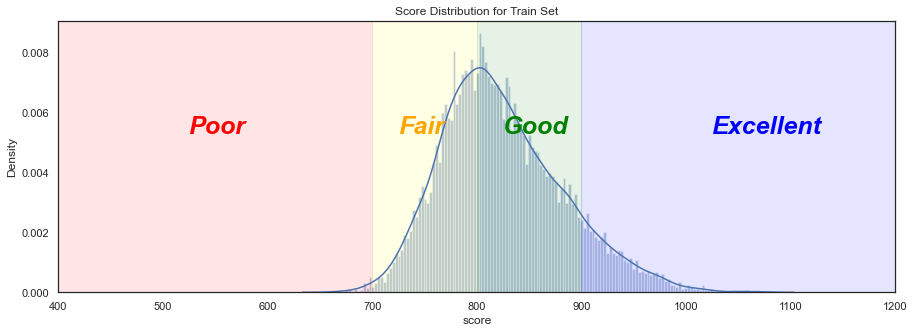

In [66]:
# Plotting the Scores for Train set

f, axes = plt.subplots(figsize=(15,5))
plt.xlim(400,1200)
sns.distplot(Scorecard_train['score'], bins = 150)
plt.axvspan(400,700, alpha=0.1, color='red')
plt.axvspan(700,800, alpha=0.1, color='yellow')
plt.axvspan(800,900, alpha=0.1, color='green')
plt.axvspan(900,1200, alpha=0.1, color='blue')
plt.text(525, 0.0053, 'Poor', color='red', fontweight='bold', style='italic', fontsize=25)
plt.text(725, 0.0053, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=25)
plt.text(825, 0.0053, 'Good', color='green', fontweight='bold', style='italic', fontsize=25)
plt.text(1025, 0.0053, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=25)
plt.title('Score Distribution for Train Set')
plt.show()

## Testing

LogisticRegression(max_iter=1000)
[[3001  294]
 [ 611  594]]
AUC score:  0.8284774491716985
Logloss :  0.43420141100276244


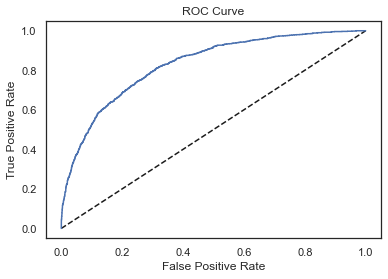

In [67]:
# Checking the AUC & plotting ROC curve

performancepara1(Logistic,X_test,Y_test)

LogisticRegression(max_iter=1000)


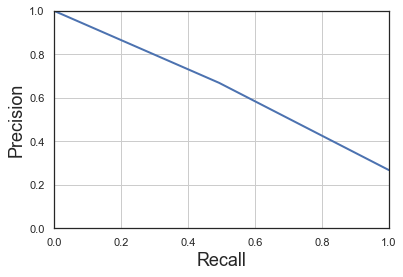

In [68]:
# Plotting the Precision vs Recall

performancepara2(Logistic,X_test,Y_test)

In [69]:
def scorecard(data, model):
    coefficients = pd.concat([pd.DataFrame(data[features].columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coefficients.columns = ['Feature','Coef']
    coefficients = coefficients.set_index('Feature')
    
    scorecard = data[coefficients.index].apply(lambda x: x*coefficients['Coef'].T,axis=1)

    scorecard['logit'] = scorecard[list(scorecard.columns)].sum(axis=1)

    ## Score card:

    target_score = 900
    target_odds = 30
    pts_double_odds = 20

    factor = pts_double_odds/np.log(2)
    offset = target_score - factor * np.log(target_odds)

    scorecard['score'] = offset + factor * scorecard['logit']
    return scorecard

In [70]:
Scorecard_test = scorecard(X_test, Logistic)

In [71]:
Scorecard_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio,logit,score
ID,,,,,,,,,,,,,,,,,,
293833,0.036421,0.010957,-0.082060,0.015502,0.058811,-0.082917,-0.024057,0.042450,0.158605,-0.055578,-0.105742,-0.038918,0.900207,-0.077479,1.672811,0.072833,2.501848,874.050251
296365,-0.054227,0.014692,-0.082060,-0.011259,0.058811,0.069084,-0.024057,-0.090035,0.158605,-0.055578,-0.105742,0.053173,-0.281809,-0.009467,1.405157,0.072833,1.118122,834.124365
272604,-0.054227,0.010957,-0.042352,0.028204,0.139400,-0.082917,0.010562,-0.152818,-0.112902,0.329278,0.183011,0.153410,0.381356,-0.554151,0.968795,0.025182,1.230790,837.375275
278528,0.036421,0.033368,0.012842,-0.011259,-0.183016,-0.082917,0.010562,0.042450,-0.112902,-0.055578,-0.469265,-0.289218,0.000000,0.174784,0.000000,-0.210327,-1.104054,770.005916
300098,0.179338,0.014692,-0.082060,-0.065554,0.058811,-0.082917,-0.024057,0.042450,0.158605,-0.055578,-0.105742,-0.153441,-0.190747,0.143892,-1.121684,0.072833,-1.211158,766.915557


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


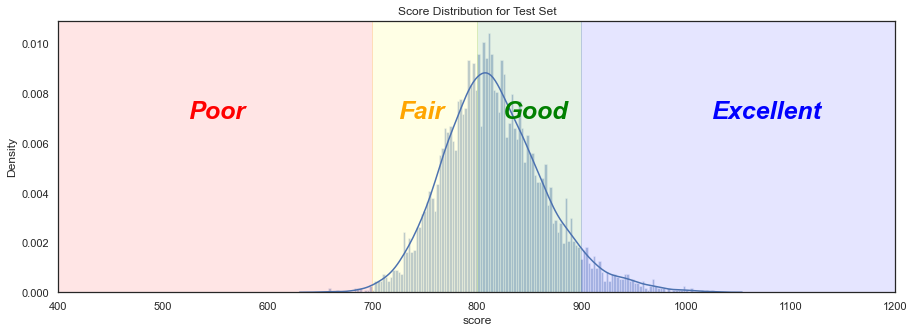

In [72]:
# Plotting the Scores for Test set

f, axes = plt.subplots(figsize=(15, 5))
plt.xlim(400,1200)
sns.distplot(Scorecard_test['score'], bins = 150)
plt.axvspan(400,700, alpha=0.1, color='red')
plt.axvspan(700,800, alpha=0.1, color='yellow')
plt.axvspan(800,900, alpha=0.1, color='green')
plt.axvspan(900,1200, alpha=0.1, color='blue')
plt.text(525, 0.007, 'Poor', color='red', fontweight='bold', style='italic', fontsize=25)
plt.text(725, 0.007, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=25)
plt.text(825, 0.007, 'Good', color='green', fontweight='bold', style='italic', fontsize=25)
plt.text(1025, 0.007, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=25)
plt.title('Score Distribution for Test Set')
plt.show()

## Final Model

Finally, we fit the model on the whole dataset and get the scores. In reality we will use the Trained and Tested model for predicting the Scores.

In [73]:
logreg = LogisticRegression().fit(Final_DS[features], Final_DS[target])

In [74]:
ScoreCard_Final = scorecard(Final_DS, logreg)
ScoreCard_Final.head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio,logit,score
ID,,,,,,,,,,,,,,,,,,
250263,-0.046989,0.025338,-0.039283,-0.003831,0.142173,-0.054336,0.015902,0.03562,0.167928,-0.057909,-0.100951,0.644039,-0.024153,0.098915,2.329226,0.025591,3.157280,892.962029
250290,-0.046989,0.050882,0.091986,0.012329,-0.041630,-0.101550,0.015902,0.03562,-0.119538,-0.057909,0.479499,-0.036335,1.336984,-0.197572,0.000000,-0.213747,1.207931,836.715710
250249,0.094351,0.008321,-0.039283,-0.003831,-0.024505,-0.054336,0.015902,0.03562,-0.119538,-0.057909,0.416230,-0.118791,-0.187605,0.074503,0.149661,0.074017,0.262807,809.445186
249516,0.031560,0.008321,0.057520,0.012329,0.118877,-0.072399,0.015902,0.03562,0.167928,-0.057909,-0.100951,-0.188259,1.336984,0.252883,0.000000,0.025591,1.643997,849.297911
249827,-0.046989,0.008321,-0.105252,-0.004922,-0.186657,-0.072399,0.015902,-0.11618,0.167928,-0.057909,-0.100951,-0.033091,1.336984,-0.027463,-0.719531,0.074017,0.131807,805.665333


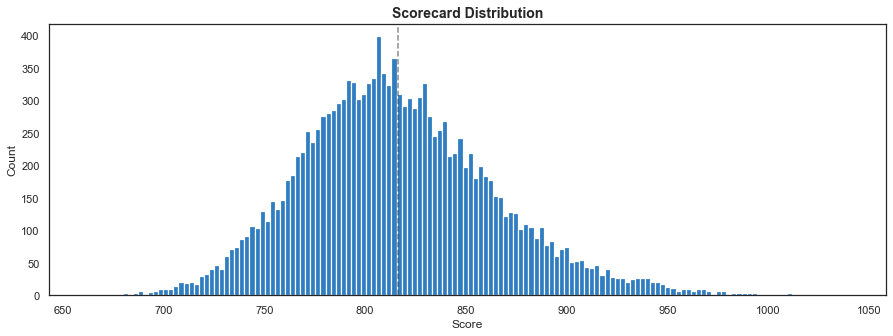

In [75]:
# Plotting the Distribution of Scores
plt.figure(figsize=(15,5))

plt.hist(ScoreCard_Final['score'],
         bins=150,
         edgecolor='white',
         color = '#317DC2',
         linewidth=1.2)

#plt.xlim(231,750)
plt.title('Scorecard Distribution', fontweight="bold", fontsize=14)
plt.axvline(ScoreCard_Final['score'].mean(), color='k', linestyle='dashed', linewidth=1.5, alpha=0.5)
plt.xlabel('Score')
plt.ylabel('Count');

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


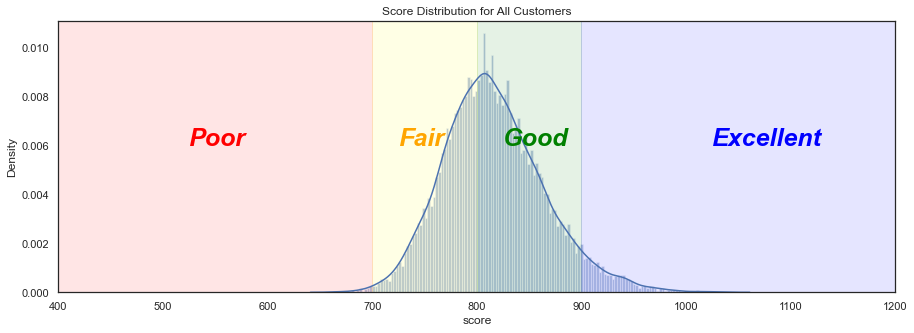

In [76]:
# Plotting the Scores Groups for Final Dataset

f, axes = plt.subplots(figsize=(15, 5))
plt.xlim(400,1200)
sns.distplot(ScoreCard_Final['score'], bins = 150)
plt.axvspan(400,700, alpha=0.1, color='red')
plt.axvspan(700,800, alpha=0.1, color='yellow')
plt.axvspan(800,900, alpha=0.1, color='green')
plt.axvspan(900,1200, alpha=0.1, color='blue')
plt.text(525, 0.006, 'Poor', color='red', fontweight='bold', style='italic', fontsize=25)
plt.text(725, 0.006, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=25)
plt.text(825, 0.006, 'Good', color='green', fontweight='bold', style='italic', fontsize=25)
plt.text(1025, 0.006, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=25)
plt.title('Score Distribution for All Customers')
plt.show()

## Survival Analysis 

Survival analysis is a branch of statistics for analyzing the expected duration of time until one event happen.
To analyze the defaulters on a lifetime basis, we will use Kaplan Meier method to develop Survival Analysis. Tha advantage of survival models is it not only predicts whether the customer defaults or not but also the time when the default occurs.

References:
- https://en.wikipedia.org/wiki/Survival_analysis

In [77]:
#pip install lifelines

In [78]:
#from lifelines import KaplanMeierFitter
import lifelines

## Reading the Data

In [79]:
Mortgage = pd.read_csv('mortgage.csv')

In [80]:
print(Mortgage.shape)

(622489, 23)


In [81]:
Mortgage.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.2,226.29,2.899137,4.7,0,0,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.2,225.10,2.151365,4.7,0,0,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.2,222.39,2.361722,4.4,0,0,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
3,1,28,-7,25,113,40483.89,24.735883,9.2,219.67,1.229172,4.6,0,0,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
4,1,29,-7,25,113,40367.06,24.925476,9.2,217.37,1.692969,4.5,0,0,1,0,45000.0,715,69.4,9.2,87.03,0,0,0


## Data Preporcessing

In [82]:
# Handling Missing values by Filling them with NA
Mortgage['LTV_time'] = Mortgage.LTV_time.fillna(Mortgage.LTV_time.mean())

In [83]:
# Converting Episodic Data to Static Data
Mortgage_static = Mortgage.groupby("id").agg(np.max).reset_index()

In [84]:
print(Mortgage_static.shape)

(50000, 23)


In [85]:
Mortgage_static.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,48,-7,25,113,41303.42,28.963629,9.200,226.29,3.029499,10.0,0,0,1,0,45000.0,715,69.4,9.200,87.03,1,0,1
1,2,26,18,25,138,105826.38,65.469851,7.680,226.29,2.899137,4.7,0,0,1,0,107200.0,558,80.0,7.680,186.91,0,1,2
2,3,29,-6,25,114,44866.18,31.459735,11.375,226.29,2.899137,4.7,0,0,1,0,48600.0,680,83.6,8.750,89.58,0,1,2
3,4,60,-2,25,119,61031.10,49.156858,11.000,226.29,3.029499,10.0,0,0,1,0,63750.0,587,81.8,10.500,97.99,0,0,0
4,5,27,18,25,138,52295.07,66.346343,9.155,226.29,2.899137,4.7,0,0,1,0,52800.0,527,80.0,9.155,186.91,0,1,2


In [86]:
# Checking the 30th Quantile of Balance at Origin Time

Mortgage_static['balance_orig_time'].quantile(0.3)

Mortgage_static['Low_balance'] = 1

Mortgage_static.loc[(Mortgage_static['balance_orig_time'] > Mortgage_static['balance_orig_time'].quantile(0.3)),'Low_balance'] = 0

## Exploratory Data Analysis

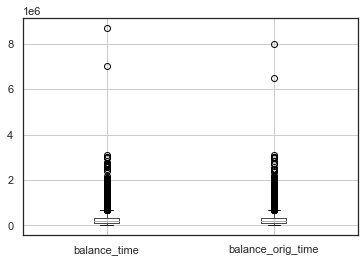

In [87]:
temp = Mortgage_static.boxplot(['balance_time', 'balance_orig_time'])

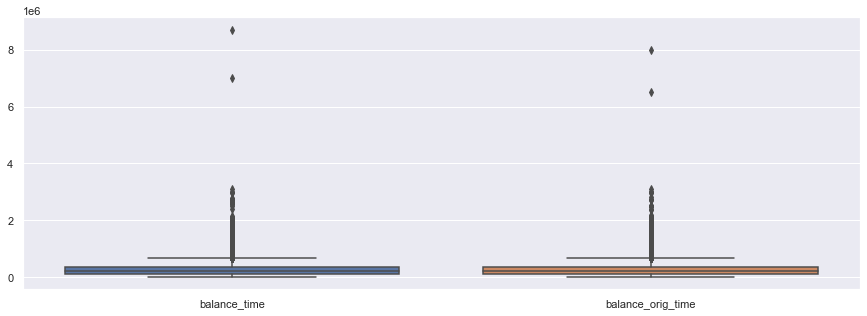

In [88]:
sns.set(rc={'figure.figsize':(15,5)})
temp = sns.boxplot(data = Mortgage_static[['balance_time', 'balance_orig_time']])

<AxesSubplot:ylabel='status_time'>

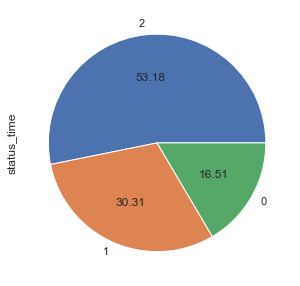

In [89]:
# Analyzing the Status Time
Mortgage_static["status_time"].value_counts().plot.pie(autopct='%.2f', figsize=(15,5))

## Lifeline Plotting

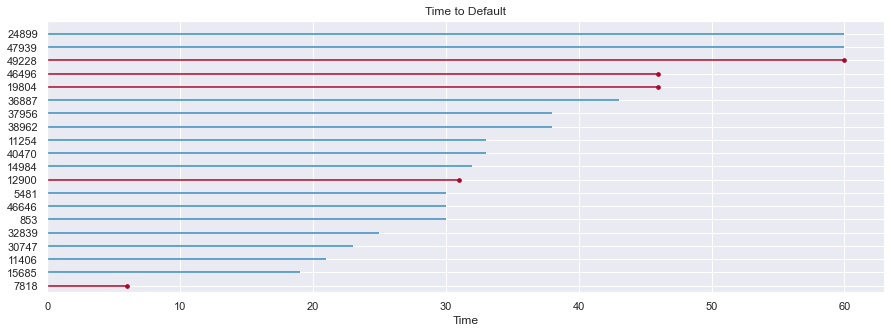

In [90]:
from lifelines.plotting import plot_lifetimes

df_temp = Mortgage_static.sample(20)
plot = plot_lifetimes(df_temp["time"], event_observed = df_temp["Low_balance"])
plot.set_xlabel("Time")
plot.set_title("Time to Default")
plt.show()

## Kaplan Meier Estimator

The Kaplan–Meier estimator, also known as the product limit estimator, is a non-parametric statistic used to estimate the survival function from lifetime data. 

A plot of the Kaplan–Meier estimator is a series of declining horizontal steps which, with a large enough sample size, approaches the true survival function for that population. The value of the survival function between successive distinct sampled observations ("clicks") is assumed to be constant.

References:
- https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

In [91]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

In [92]:
# Fitting on static data: TIME indicates the last observed timestep, TARGET indicates whether the customer defaulted
kmf.fit(Mortgage_static['time'], Mortgage_static['Low_balance'], label='Kaplan Meier Estimator')

<lifelines.KaplanMeierFitter:"Kaplan Meier Estimator", fitted with 50000 total observations, 34995 right-censored observations>

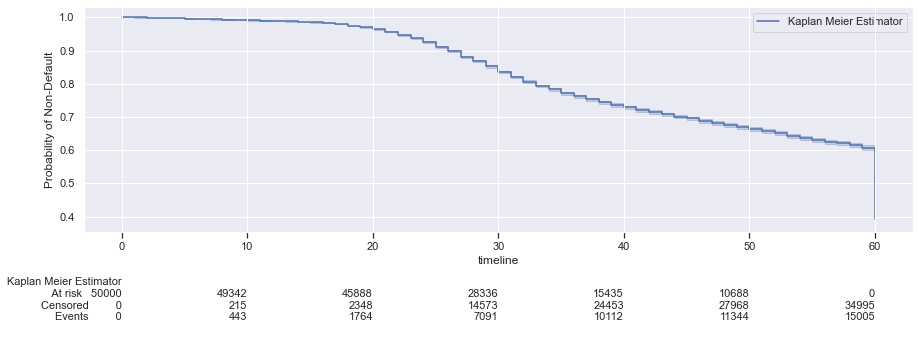

In [93]:
# Plotting the Survival Function
temp = kmf.plot_survival_function(at_risk_counts=True,figsize=(13,5))
temp.set_ylabel('Probability of Non-Default')
plt.show()

In [94]:
# Checking the Median default_time?
median_default = Mortgage_static.query("Low_balance == 1")["time"].median()
print(median_default)

31.0


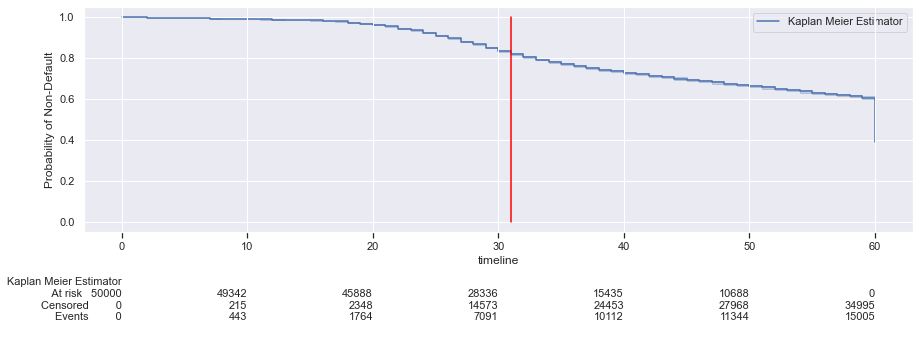

In [95]:
# Adding to Plot
temp = kmf.plot_survival_function(at_risk_counts=True,figsize=(13,5))
temp.set_ylabel('Probability of Non-Default')
plt.plot([median_default, median_default], [0,1], 'k-', c="red")
plt.show()

In [96]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,50000,50000
1.0,22,15,7,0,50000
2.0,37,25,12,0,49978
3.0,57,44,13,0,49941
4.0,56,39,17,0,49884
...,...,...,...,...,...
56.0,223,70,153,0,8996
57.0,231,61,170,0,8773
58.0,245,93,152,0,8542


<AxesSubplot:xlabel='timeline'>

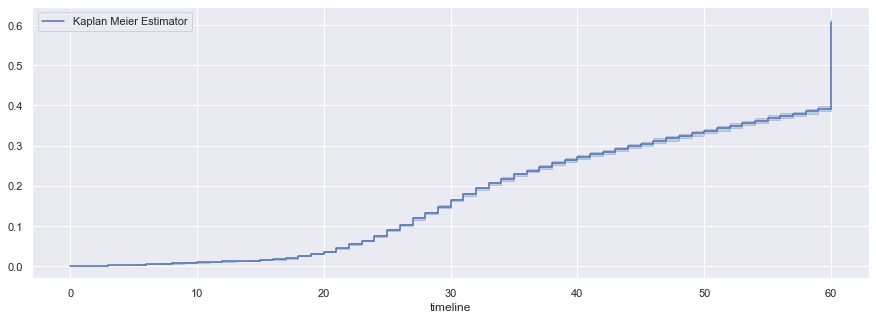

In [97]:
# Plotting the Cumulative Hazard Function
kmf.plot_cumulative_density()

<AxesSubplot:ylabel='Low_balance'>

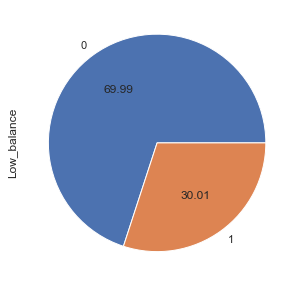

In [98]:
# Analyzing the Low_balance
Mortgage_static["Low_balance"].value_counts().plot.pie(autopct='%.2f', figsize=(15,5))

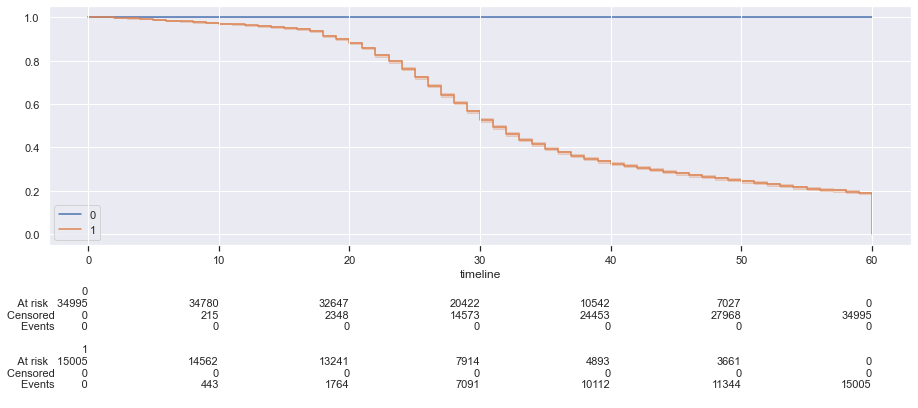

In [99]:
# Comparing the Two Groups

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

fig, temp = plt.subplots(1,1 , figsize=(13,6))

# subset data
df1 = Mortgage_static.loc[Mortgage_static["Low_balance"] == 0,:]
df2 = Mortgage_static.loc[Mortgage_static["Low_balance"] == 1,:]

# fit subset gender = male
temp = kmf1.fit(df1['time'], df1['Low_balance'], label='0').plot_survival_function(ax=temp)

# fit subset gender = female
temp = kmf2.fit(df2['time'], df2['Low_balance'], label='1').plot_survival_function(ax=temp)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf1, kmf2, ax=temp)
plt.tight_layout()

## Logrank Test

The log rank test is a statistical methodology for comparing the distribution of time until the occurrence of an event of interest in independent groups. The log rank test provides a method for comparing “risk-adjusted” event rates, useful when test subjects in a study are subject to varying degrees of opportunity to experience the event. 

References:
- https://www.sciencedirect.com/topics/medicine-and-dentistry/log-rank-test

In [100]:
# We now use logrank test to assess whether there is a difference between Males and Females in time to default

from lifelines.statistics import logrank_test

# Null-Hypothesis: No difference between the two groups
logrank_result = logrank_test(df1['time'], df2['time'], event_observed_A = df1['Low_balance'],event_observed_B=df2['Low_balance'])

# We can reject the Null-Hypothesis (p < 0.05)
logrank_result.summary 

,test_statistic,p,-log2(p)
0,37151.577469,0.0,inf


## Cox Proportional Hazard Model (time varying)

The above mentioned methods - `Kaplan-Meier` curves and `Logrank Test`, are examples of Univariate Analysis and describe the survival according to one factor under investigation, but ignore the impact of any others. 

An alternative method is the `Cox Proportional Hazards Regression Analysis`, which works for both quantitative predictor variables and for categorical variables. Furthermore, the Cox regression model extends survival analysis methods to assess simultaneously the effect of several risk factors on survival time.

The purpose of this model is to evaluate simultaneously the effect of several factors on survival. In other words, it allows us to examine how specified factors influence the rate of a particular event happening at a particular point in time. This rate is commonly referred as the hazard rate. 

The Cox model is expressed by the hazard function denoted by h(t). Briefly, the hazard function can be interpreted as the risk of dying at time t. It can be estimated as follow:

![COX](./img/cox.png)

where -
- t represents the survival time
- h(t) is the hazard function determined by a set of p covariates (x1,x2,...,xp)
- the coefficients (b1,b2,...,bp) measure the impact (i.e., the effect size) of covariates.
- the term h0 is called the baseline hazard.

The quantities exp(bi) are called hazard ratios (HR). A hazard ratio above 1 indicates a covariate that is positively associated with the event probability, and thus negatively associated with the length of survival.

To summarize,
- HR = 1: No effect
- HR < 1: Reduction in the hazard
- HR > 1: Increase in Hazard

References:
- http://www.sthda.com/english/wiki/cox-proportional-hazards-model

In [101]:
# Checking all the Comumns 
Mortgage_static.columns

Index(['id', 'time', 'orig_time', 'first_time', 'mat_time', 'balance_time',
       'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time',
       'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time',
       'investor_orig_time', 'balance_orig_time', 'FICO_orig_time',
       'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time',
       'default_time', 'payoff_time', 'status_time', 'Low_balance'],
      dtype='object')

In [102]:
# Keeping only required columns
Mortgage_CPHM = Mortgage_static[["id", "time", "default_time", "hpi_time", "gdp_time", "uer_time", "balance_time", 
                              "interest_rate_time", "FICO_orig_time", "LTV_time", "Low_balance"]].set_index("id")

Mortgage_CPHM["first_time"] = 0

In [103]:
Mortgage_CPHM.head()

,time,default_time,hpi_time,gdp_time,uer_time,balance_time,interest_rate_time,FICO_orig_time,LTV_time,Low_balance,first_time
id,,,,,,,,,,,
1,48,1,226.29,3.029499,10.0,41303.42,9.200,715,28.963629,1,0
2,26,0,226.29,2.899137,4.7,105826.38,7.680,558,65.469851,1,0
3,29,0,226.29,2.899137,4.7,44866.18,11.375,680,31.459735,1,0
4,60,0,226.29,3.029499,10.0,61031.10,11.000,587,49.156858,1,0
5,27,0,226.29,2.899137,4.7,52295.07,9.155,527,66.346343,1,0


In [104]:
from lifelines import CoxTimeVaryingFitter

# Note: credit_tv contains both time varying and static variables 
ctv = CoxTimeVaryingFitter()
ctv.fit(Mortgage_CPHM, id_col = Mortgage_CPHM.index, event_col="Low_balance", start_col="first_time", stop_col="time", show_progress=True)
ctv.summary

Iteration 9: norm_delta = 0.00000, step_size = 1.00000, ll = -126412.63866, newton_decrement = 0.00000, seconds_since_start = 3.8Convergence completed after 9 iterations.


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
default_time,0.458467,1.581648,2.072664e-02,0.417844,0.499091,1.518684,1.647223,22.119720,2.041931e-108,357.738300
hpi_time,-0.015452,0.984667,6.017710e-04,-0.016631,-0.014272,0.983507,0.985829,-25.676827,2.121726e-145,480.594335
gdp_time,1.162542,3.198054,1.682787e-02,1.129560,1.195524,3.094296,3.305291,69.084347,0.000000e+00,inf
uer_time,-0.715506,0.488945,7.047466e-03,-0.729319,-0.701693,0.482237,0.495745,-101.526689,0.000000e+00,inf
balance_time,-0.000020,0.999980,1.987050e-07,-0.000021,-0.000020,0.999979,0.999980,-101.944714,0.000000e+00,inf
interest_rate_time,0.018349,1.018518,3.309298e-03,0.011863,0.024835,1.011934,1.025146,5.544717,2.944305e-08,25.017497
FICO_orig_time,0.000221,1.000221,1.219057e-04,-0.000018,0.000460,0.999982,1.000460,1.811959,6.999251e-02,3.836656
LTV_time,0.011034,1.011095,3.696597e-04,0.010309,0.011758,1.010363,1.011828,29.848742,9.115061e-196,647.909654


In [105]:
# Inspecting the p-values
round(ctv.summary['p'], 4)

covariate
default_time          0.00
hpi_time              0.00
gdp_time              0.00
uer_time              0.00
balance_time          0.00
interest_rate_time    0.00
FICO_orig_time        0.07
LTV_time              0.00
Name: p, dtype: float64

<AxesSubplot:xlabel='log(HR) (95% CI)'>

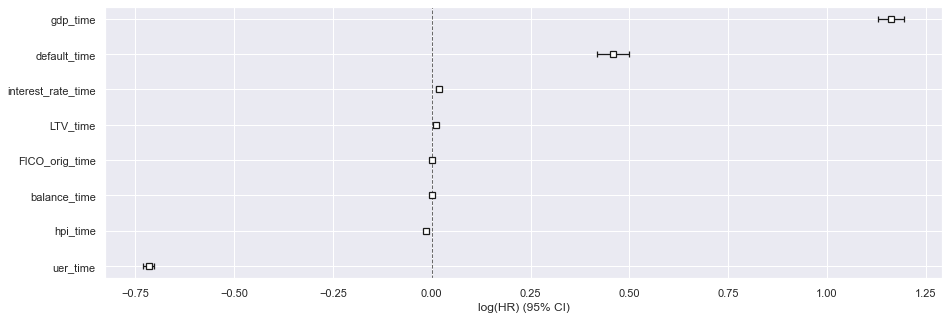

In [106]:
ctv.plot()

In [107]:
# Checknig the Parameter Values
print(round(ctv.params_, 6))

covariate
default_time          0.458467
hpi_time             -0.015452
gdp_time              1.162542
uer_time             -0.715506
balance_time         -0.000020
interest_rate_time    0.018349
FICO_orig_time        0.000221
LTV_time              0.011034
dtype: float64


<AxesSubplot:>

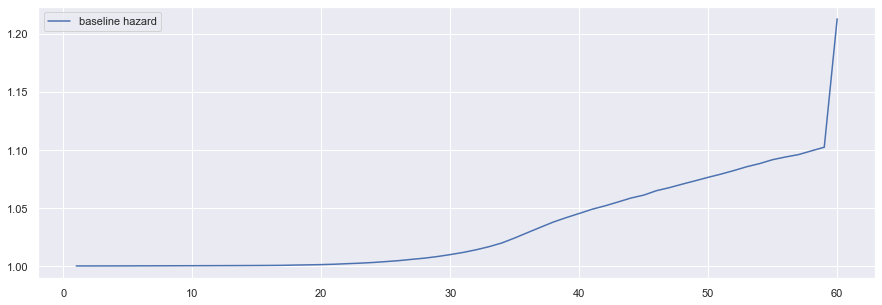

In [108]:
np.exp(ctv.baseline_cumulative_hazard_).plot()

In [109]:
# Interpreting the Results (under ceteris paribus assumption): 

print('\n An additional increase in Current Balance could have increased the probability of Low balance by {:.3f}%'.format((np.exp(-0.000020) - 1)*100))

print('\n An additional increase in Interest Rate could have increased the probability of Low balance by {:.3f}%'.format((np.exp(0.018349) - 1)*100))

print('\n An additional increase in Unemployment Rate (due in the future) increases the probability of Low balance by {:.3f}%'.format((np.exp(-0.715506) - 1)*100))

print('\n An additional increase in GDP (due in the future) increases the probability of Low balance by {:.3f}%'.format((np.exp(1.162542) - 1)*100))


 An additional increase in Current Balance could have increased the probability of Low balance by -0.002%

 An additional increase in Interest Rate could have increased the probability of Low balance by 1.852%

 An additional increase in Unemployment Rate (due in the future) increases the probability of Low balance by -51.106%

 An additional increase in GDP (due in the future) increases the probability of Low balance by 219.805%
